In [42]:
import sys
sys.path.insert(0, '..')
%matplotlib inline
from IPython import display
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
from mxnet.gluon import data as gdata
import sys
import time
from mxnet import gluon, init, autograd
from mxnet.gluon import loss as gloss, nn
import mxnet as mx
import numpy as np
import mxnet as mx
from mxnet import nd, autograd, gluon

In [43]:
mnist_train = gdata.vision.FashionMNIST(train=True)
mnist_test = gdata.vision.FashionMNIST(train=False)
len(mnist_train), len(mnist_test)

(60000, 10000)

In [63]:
feature, label = mnist_train[0]
feature.shape, feature.dtype

2


In [64]:
label, type(label), label.dtype

(2, numpy.int32, dtype('int32'))

In [68]:
def get_mnist_labels(labels):
   text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
   return [text_labels[int(i)] for i in labels]

In [69]:
def show_mnist(images, labels):
   display.set_matplotlib_formats('svg')
   # Here _ means that we ignore (not use) variables
   _, figs = plt.subplots(1, len(images), figsize=(12, 12))
   for f, img, lbl in zip(figs, images, labels):
       f.imshow(img.reshape((28, 28)).asnumpy())
       f.set_title(lbl)
       f.axes.get_xaxis().set_visible(False)
       f.axes.get_yaxis().set_visible(False)

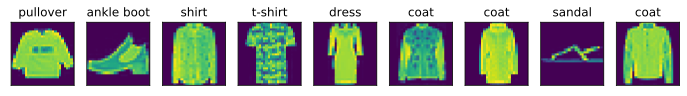

In [70]:
X, y = mnist_train[0:9]
show_mnist(X, get_mnist_labels(y))

In [49]:
batch_size = 40
transformer = gdata.vision.transforms.ToTensor()
if sys.platform.startswith('win'):
    num_workers = 0
else:
    num_workers = 4
train_iter = gdata.DataLoader(mnist_train.transform_first(transformer),
   batch_size, shuffle=True,
   num_workers=num_workers)
test_iter = gdata.DataLoader(mnist_test.transform_first(transformer),
   batch_size, shuffle=False,
   num_workers=num_workers)


In [50]:
start = time.time()
for X, y in train_iter:
    continue
'%.2f sec' % (time.time() - start)

'1.43 sec'

In [51]:
#Initialize the Model
def init(net, optimizer='sgd', learning_rate=0.1, weight_decay=1e-6, ctx=mx.cpu()):
   net.collect_params().initialize(mx.init.Xavier(magnitude=2.24), ctx=ctx)
   trainer = gluon.Trainer(net.collect_params(),
                           optimizer,
                           {'learning_rate': learning_rate, 'wd': weight_decay})
   return trainer

In [52]:
# Computing Accuracy
def accuracy(data_iterator, net,ctx=mx.cpu()):
   acc = mx.metric.Accuracy()
   for (data, label) in data_iterator:
       data = data.as_in_context(ctx)
       label = label.as_in_context(ctx)
       output = net(data)
       predictions = mx.nd.argmax(output, axis=1)
       acc.update(preds=predictions, labels=label)
   return acc.get()[1]

In [53]:
#Training the Model
def train(net, trainer, train_data, validation_data, epochs, ctx=mx.cpu()):
   training_accuracies = []
   validation_accuracies = []
   softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()
   for e in range(epochs):
       tic = time.time()
       for (data, label) in train_data:
           data  = data.as_in_context(ctx)
           label = label.as_in_context(ctx)
           with autograd.record():
               output = net(data)
               loss = softmax_cross_entropy(output, label)
               loss.backward()
           trainer.step(data.shape[0])
       toc = time.time()
       train_accuracy = accuracy(train_data, net)
       training_accuracies.append(train_accuracy)
       validation_accuracy = accuracy(validation_data, net)
       validation_accuracies.append(validation_accuracy)
       print("Epoch#%d Time=%.2f Training=%.4f Validation=%.4f Diff=%.4f"
             % (e, toc-tic, train_accuracy, validation_accuracy, train_accuracy-validation_accuracy))
   return training_accuracies, validation_accuracies

In [54]:
#Plotting
def plot_accuracies(training_accuracies, validation_accuracies):
   epochs = len(training_accuracies)
   plt.clf()
   fig, ax = plt.subplots()
   plt.xlabel('Epochs')
   plt.ylabel('Accuracy')
   train_plot, = ax.plot(range(epochs), training_accuracies, label="Training accuracy")
   validation_plot, = ax.plot(range(epochs), validation_accuracies, label="Validation accuracy")
   plt.legend(handles=[train_plot,validation_plot])
   plt.xticks(np.arange(0, epochs, 5))
   ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.4f'))
   plt.show()

Epoch#0 Time=2.76 Training=0.8257 Validation=0.8229 Diff=0.0028
Epoch#1 Time=2.46 Training=0.8345 Validation=0.8330 Diff=0.0015
Epoch#2 Time=2.56 Training=0.8504 Validation=0.8472 Diff=0.0032
Epoch#3 Time=2.52 Training=0.8454 Validation=0.8414 Diff=0.0040
Epoch#4 Time=2.49 Training=0.8435 Validation=0.8392 Diff=0.0043
Epoch#5 Time=2.38 Training=0.8427 Validation=0.8383 Diff=0.0044
Epoch#6 Time=2.57 Training=0.8377 Validation=0.8360 Diff=0.0017
Epoch#7 Time=2.69 Training=0.8533 Validation=0.8426 Diff=0.0107
Epoch#8 Time=2.70 Training=0.8603 Validation=0.8494 Diff=0.0109
Epoch#9 Time=2.41 Training=0.8517 Validation=0.8461 Diff=0.0056
Epoch#10 Time=2.64 Training=0.8581 Validation=0.8511 Diff=0.0070
Epoch#11 Time=2.68 Training=0.8639 Validation=0.8544 Diff=0.0094
Epoch#12 Time=2.73 Training=0.8459 Validation=0.8361 Diff=0.0098
Epoch#13 Time=2.61 Training=0.8451 Validation=0.8345 Diff=0.0106
Epoch#14 Time=2.80 Training=0.8565 Validation=0.8482 Diff=0.0083
Epoch#15 Time=2.58 Training=0.8481 

<Figure size 432x288 with 0 Axes>

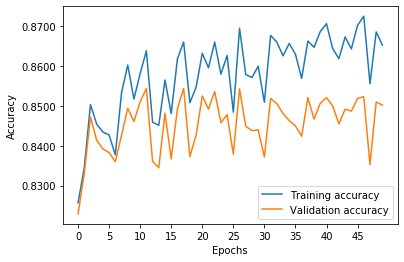

In [55]:
net = nn.Sequential()
net.add(nn.Dense(10))
net.add(nn.Dense(256, activation='relu'))
trainer = init(net)
training_accuracies, validation_accuracies = train(net, trainer, train_iter, test_iter, 50)
plot_accuracies(training_accuracies, validation_accuracies)